In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import numpy as np 
import pandas as pd
import math

from pymatgen.core import Structure, PeriodicSite

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ch4_sigma , ch4_epsilon = 3.73, 148

In [4]:
structure_list = ['ja403810k_si_003_clean']

In [5]:
# Need modification later!!
for structure in structure_list:
    structure = structure 

# Data preparation

## Get supercell

In [6]:
def get_supercell(structure):
    with open("nvt_results/%s/simulation.input" %structure, "r") as f_input:
        for line in f_input:
            if re.search("UnitCells", line):
                s1, s2, s3 = line.split()[1], line.split()[2], line.split()[3]
    supercell = [int(s1), int(s2), int(s3)]
    return supercell

In [7]:
sc = get_supercell(structure)

In [8]:
sc

[1, 1, 1]

## Read force field

### Read ff with LB mixing rule

In [8]:
uff = pd.read_csv("ff_data/uff.csv")

In [10]:
uff

,Unnamed: 0,element,epsilon,sigma,lb_sigma,lb_epsilon
0,0,Ac,16.6080,3.0985,3.399618,82.30400
1,1,Ag,18.1178,2.8045,3.234314,83.05890
2,2,Al,254.1520,4.0082,3.866599,201.07600
3,3,Am,7.0458,3.0121,3.351885,77.52290
4,4,Ar,93.1052,3.4460,3.585189,120.55260
...,...,...,...,...,...,...
98,98,Xe,167.0861,3.9235,3.825527,157.54305
99,99,Y,36.2355,2.9801,3.334033,92.11775
100,100,Yb,114.7458,2.9890,3.339007,131.37290
101,101,Zn,62.4056,2.4616,3.030143,105.20280


## Get gas sites

In [9]:
sp_cry = Structure.from_file("nvt_results/%s/Movies/System_0/Framework_0_final.vasp" %structure)
un_cry = sp_cry.get_primitive_structure()

In [10]:
uc_cry = sp_cry

In [12]:
if sc != [1, 1, 1]:
    if len(sp_cry.sites) == len(un_cry.sites):
        print("error!")

In [11]:
site_sigma = [uff.loc[uff["element"] == site.specie.symbol]["lb_sigma"].values for site in un_cry.sites]
site_epsilon = [uff.loc[uff["element"] == site.specie.symbol]["lb_epsilon"].values for site in un_cry.sites]

In [12]:
for i in range(len(un_cry.sites)):
    un_cry.sites[i].properties = {"lb_sigma": site_sigma[i], "lb_epsilon": site_epsilon[i], "weight": []}

### Read molecule movies and get the fractional coordinates in the unit cell

In [13]:
with open("nvt_results/%s/Movies/System_0/Movie_%s_%d.%d.%d_298.000000_0.000000_allcomponents.pdb" %(structure, structure, sc[0], sc[1], sc[2])) as file:
    data = file.readlines()
    atom_pos = np.array([np.array([float(i) for i in line.split()[4:7]]) for line in data if "ATOM" in line])

In [18]:
un_cry.get_sites_in_sphere(pt=atom_pos[4], r=threshold)

[]

In [14]:
# Get atoms in threshold sphere
threshold = 12
sphere_sites = np.array([[site for site in un_cry.get_sites_in_sphere(pt=pos, r=threshold)] for pos in atom_pos], dtype=object)

In [17]:
# Calculate distance between gas and surrounding framework atoms
dist = np.array([np.array([site.distance_from_point(atom_pos[idx]) for site in sphere_sites[idx]]) 
                    for idx in range(len(atom_pos))], dtype=object)

In [18]:
# Calculate LJ potential

def lj(sigma_lb, epsilon_lb, distance):
    #distance_reduced = distance/sigma_lb
    u_lj = 4 * epsilon_lb * ((sigma_lb/distance)**12 - (sigma_lb/distance)**6)
    return u_lj

potential = np.array([np.array([lj(sphere_sites[i][j].properties["lb_sigma"], sphere_sites[i][j].properties["lb_epsilon"], dist[i][j]) 
                for j in range(len(sphere_sites[i]))]).flatten() 
                for i in range(len(atom_pos))], dtype=object)

In [19]:
for idx in range(len(atom_pos)):
    if len(sphere_sites[idx]) != len(dist[idx]):
        print("error in distance")
    if len(sphere_sites[idx]) != len(potential[idx]):
        print("error in potential")

In [20]:
po_ana = np.hstack(potential)

In [21]:
print(po_ana.min())
print(po_ana.max())

-104.05861397527575
796.007079027746


(array([15., 33., 81., 66., 32., 34., 29., 24., 15., 21.,  9., 13., 10.,
         7.,  6.,  8.,  6.,  3.,  4.,  5.,  6.,  6.,  2.,  1.,  1.,  3.,
         1.,  2.,  1.,  1.,  1.,  1.,  6.,  1.,  3.,  1.,  3.,  0.,  0.,
         1.,  0.,  1.,  2.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
         0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-104.05861398,  -95.05795705,  -86.05730012,  -77.05664319,
         -68.05598626,  -59.05532933,  -50.0546724 ,  -41.05401547,
         -32.05335854,  -23.05270161,  -14.05204467,   -5.05138774,
           3.94926919,   12.94992612,   21.95058305,   30.95123998,
          39.95189691,   48.95255384,   57.95321077,   66.9538677 ,
          75.95452463,   84.95518156,   93.95583849,  102.95649542,
         111.95715235,  12

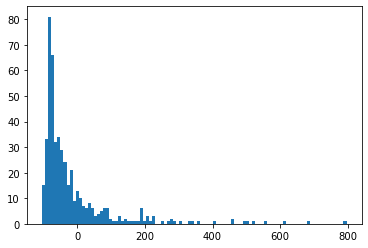

In [22]:
plt.hist(po_ana, bins=100)

In [23]:
po_sigmoid = np.exp(-po_ana/abs(np.min(po_ana))) / np.sum(np.exp(-po_ana/abs(np.min(po_ana))))

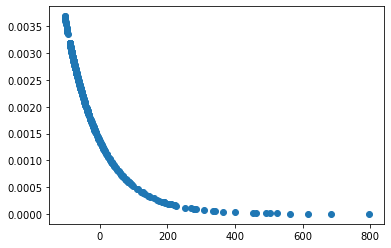

In [24]:
plt.scatter(po_ana, po_sigmoid)

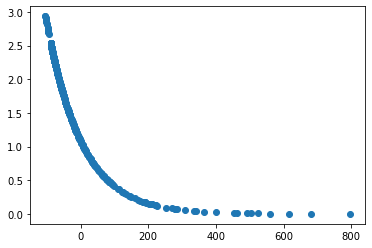

In [25]:
plt.scatter(po_ana, po_sigmoid*abs(po_ana.max()))

## Assign weight to each site

In [26]:
idx = 0
for i in range(sphere_sites.shape[0]):
    for j in range(len(sphere_sites[i])):
        sphere_sites[i][j].properties["weight"].append(po_sigmoid[idx])
        idx += 1

In [27]:
weights = np.array([np.sum(site.properties["weight"]) for site in un_cry.sites])

In [28]:
atom_lst = [site.specie.symbol for site in un_cry.sites]

In [29]:
def atom_label(list):
    ele = np.unique(np.array(list))
    list_label = list.copy()
    count = [0] * len(ele)
    for idx in range(len(list)):
        for idj in range(len(ele)):
            if list[idx] == ele[idj]:
                count[idj] += 1
                list_label[idx] = list[idx] + str(count[idj])
    return list_label

In [30]:
atom_lst_test = atom_label(atom_lst)

# Analysis

## Violinplot

In [31]:
key_weight = {}
for idx in range(len(weights)):
    if atom_lst[idx] not in key_weight:
        key_weight.update({atom_lst[idx]: weights[idx]})
    else:
        key_weight[atom_lst[idx]] = np.append(key_weight[atom_lst[idx]], weights[idx])

Text(0, 0.5, 'weight')

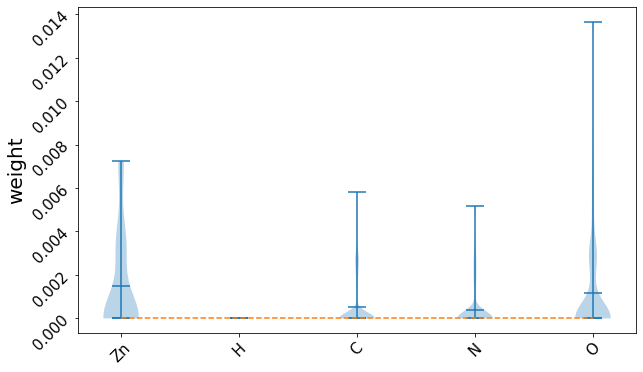

In [32]:
ele = [key for key in key_weight.keys()]
data = [key_weight[key] for key in key_weight.keys()]
pos = np.arange(len(ele))

fs = 15  # fontsize

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

axs.violinplot(data, pos, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True)
axs.plot([0,len(ele)-1], [0, 0], linestyle='dashed')
axs.set_xticks(np.arange(len(ele)))
axs.set_xticklabels(ele)
axs.tick_params(labelsize=fs, labelrotation=45)
axs.set_ylabel("weight", fontdict={"fontsize": 20})

## cif visualization

In [33]:
from ase_notebook import AseView, ViewConfig
import ase.io

In [34]:
ase_crys = ase.io.read("nvt_results/%s/%s.cif" %(structure, structure))

In [35]:
config = ViewConfig()
config.element_radii = "custom"
config.atom_font_size=12
config.axes_length=30
config.canvas_size=(900, 900)
config.zoom=1.5
config.show_bonds=True

In [36]:
ase_view = AseView(config, radii=weights*10)

radii defined


In [37]:
gui = ase_view.make_render(
    ase_crys, center_in_uc=True)
gui

yes


/home/xiaoqi/anaconda3/envs/ml/lib/python3.7/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 691.4814299883975), p…

# Change weight order according to cif